In [26]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import norm
# %matplotlib notebook
# %run '../../plot_setup.py'

In [27]:
# Create a square gird in k-space
k0x, k0y = -60, -60
dk = 0.05

kx = np.arange(k0x, -k0x, dk)
ky = np.arange(k0y, -k0y, dk)

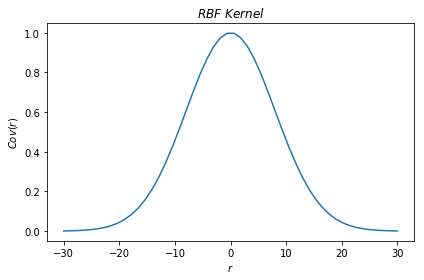

In [30]:
# amplitude and scale of the RBF kernel
Amp, scale = 1, 8

x_pl = np.linspace(-30, 30, 50)
plt.plot(x_pl, Amp * np.exp(-0.5 * x_pl ** 2 / scale ** 2))
plt.xlabel(r'$r$')
plt.ylabel(r'$Cov(r)$')
plt.title('$RBF\ Kernel$')
plt.tight_layout()
plt.show()

In [4]:
# define the kernel as a function
def corr(x0, x1, Amp, scale):
    r_sq = (x0[0] - x1[0]) ** 2 + (x0[1] - x1[1]) ** 2
    return Amp * np.exp(-0.5 * r_sq / scale ** 2)

In [5]:
# define the power spectrum to generate the fields
# The power spectrum is related to the kernel defined above via a fourier transform and gives the variance for
#    of the amplitude of each wavelength scale
# the power spectrum for a Gaussian is a Gaussian

Pk = 2 * np.pi * Amp * scale ** 2 *\
     np.exp(-0.5 * scale ** 2 * (kx ** 2 + ky[:, None] ** 2))
print(Pk.shape)

(2400, 2400)


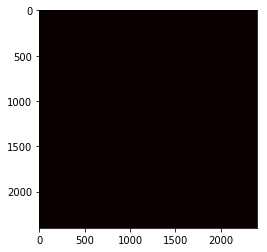

In [6]:
plt.imshow(Pk, cmap='hot', interpolation='nearest')
plt.show()

In [31]:
# sample delta_k from the corresponding gaussian with variance given by the power spectrum
Ak, Bk = np.random.normal(0, scale=1, size=(2, len(kx), len(ky)))
delta_k = (2 * np.pi / dk) * np.sqrt(Pk) * (Ak + 1j * Bk)

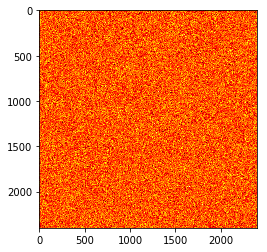

In [35]:
plt.imshow(Ak, cmap='hot', interpolation='nearest')
plt.show()

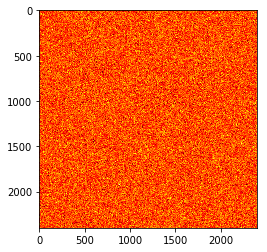

In [36]:
plt.imshow(Bk, cmap='hot', interpolation='nearest')
plt.show()

In [41]:
# Inverse fourier transform to get the field in real space
delta_x = np.fft.ifft2(delta_k)

In [44]:
# the locations in real space
x = np.fft.fftfreq(len(kx), d = dk / (2 * np.pi))
y = np.fft.fftfreq(len(ky), d = dk / (2 * np.pi))

In [48]:
X, Y = np.meshgrid(x, y)

In [50]:
print(min(x), max(x), x[1]-x[0], X.shape)

-62.8318530718 62.7794931942 0.0523598775598 (2400, 2400)


In [51]:
# shift the delta_x such that the zero-frequency are at the center
delta_x *= (dk ** 2 * len(kx) * len(ky) / (2 * np.pi) ** 2) *\
           np.exp(complex(0,1) * (X * k0x + Y * k0y))

In [52]:
# apply the same shift to the locations and the data
X, Y = np.fft.fftshift(X), np.fft.fftshift(Y)
delta_x = np.fft.fftshift(delta_x)

In [53]:
field = np.imag(delta_x)
# field = np.real(delta_x)

# both real and imaginary part are fields that are independent

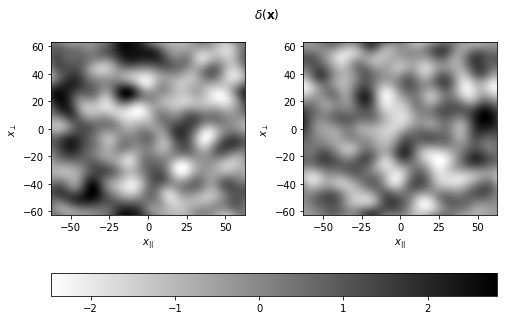

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 5))

surf = ax[0].pcolormesh(X, Y, np.imag(delta_x), cmap=plt.cm.binary)
surf = ax[1].pcolormesh(X, Y, np.real(delta_x), cmap=plt.cm.binary)
ax[0].set_xlabel(r'$x_{||}$')
ax[0].set_ylabel(r'$x_\perp$')

ax[1].set_xlabel(r'$x_{||}$')
ax[1].set_ylabel(r'$x_\perp$')
fig.colorbar(surf, ax=ax.ravel().tolist(), orientation='horizontal')
plt.suptitle(r'$\delta(\mathbf{x})$')

plt.subplots_adjust(bottom=0.4, wspace=0.3)
plt.savefig('delta_field.png')
plt.show()

In [62]:
np.ravel(field.shape)

array([2400, 2400])

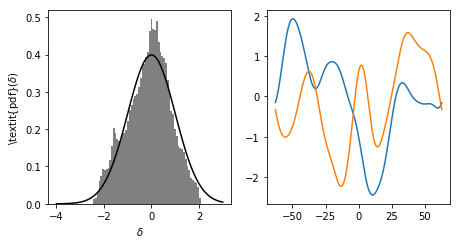

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(6.5, 3.5))
__ = ax[0].hist(np.ravel(field), bins=60, normed=True, color='gray')

x_plot = np.linspace(-4, 3, 100)
__ = ax[0].plot(x_plot, norm.pdf(x_plot, 0, 1), '-k')

ax[0].set_ylabel(r'\textit{pdf}($\delta$)')
ax[0].set_xlabel(r'$\delta$')
ax[1].plot(X[0], field[1])
ax[1].plot(X[0], field[1200])

plt.tight_layout()
plt.show()

In [18]:
# Select a subset of points that will comprise the data
X_data = X[::100, ::80]
Y_data = Y[::100, ::80]
data = field[::100, ::80]

In [19]:
X_data.shape

(24, 30)

In [20]:
# flattened data
positions = np.vstack(map(np.ravel, [X_data, Y_data])).T
data_flat = data.flatten()

In [67]:
positions.shape

(720, 2)

In [66]:
data_flat.shape

(720,)

In [92]:
# flattened map
positions2 = np.vstack(map(np.ravel, [X, Y])).T

In [94]:
positions2.shape

(5760000, 2)

In [21]:
# Create covariance matrix for data 
cov_data = np.zeros((len(data_flat), len(data_flat)))

In [22]:
for i, ele1 in enumerate(positions):
    for j, ele2 in enumerate(positions):
        temp = corr(ele1, ele2, Amp, scale)
        cov_data[i, j] = temp

In [73]:
cov_data.shape

(720, 720)

In [104]:
for i, ele1 in enumerate(positions2):
    for j, ele2 in enumerate(positions):
        temp = corr(ele1, ele2, Amp, scale)
        cov_mapdata[i, j] = temp

KeyboardInterrupt: 

In [69]:
# create noisy data
data_noisy = data_flat + np.random.normal(scale=1., size=len(data_flat))
cov_noise = np.diag(np.ones(len(data_flat)))

In [72]:
data_noisy.shape

(720,)

In [ ]:
cov_noise.shape

In [24]:
# Weiner reconstruction
vec_map = np.dot(np.linalg.inv(cov_data + cov_noise), data_noisy)
s_rec = np.dot(cov_data, vec_map)

In [75]:
s_rec.shape

(720,)

In [79]:
X_data.shape

(24, 30)

In [80]:
Y_data.shape

(24, 30)

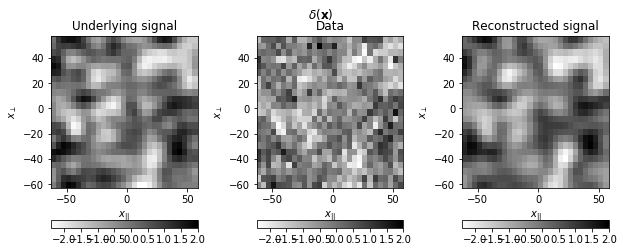

In [76]:
fig, ax = plt.subplots(ncols=3,figsize=(10, 4))


surf1 = ax[0].pcolormesh(X_data, Y_data, data, cmap=plt.cm.binary, shading='flat')
ax[0].set_title('Underlying signal')
surf2 = ax[1].pcolormesh(X_data, Y_data, np.reshape(data_noisy, X_data.shape), cmap=plt.cm.binary, shading='flat')
ax[1].set_title('Data')
surf3 = ax[2].pcolormesh(X_data, Y_data, np.reshape(s_rec, X_data.shape), cmap=plt.cm.binary)
ax[2].set_title('Reconstructed signal')

for axes in ax:
    axes.set_xlabel(r'$x_{||}$')
    axes.set_ylabel(r'$x_\perp$')
    plt.colorbar(surf1, ax=axes, orientation='horizontal')


plt.suptitle(r'$\delta(\mathbf{x})$')
plt.subplots_adjust(wspace=0.4)
plt.savefig('reconstructed_2d.pdf')
plt.show()